<a href="https://colab.research.google.com/github/Schadrackkarekezi/Neural-net-training-from-scratch/blob/main/building_NN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
#understanding derivatives
def f(x):
  return 3*x**2 - 4*x +5

In [60]:
f(3.0)

20.0

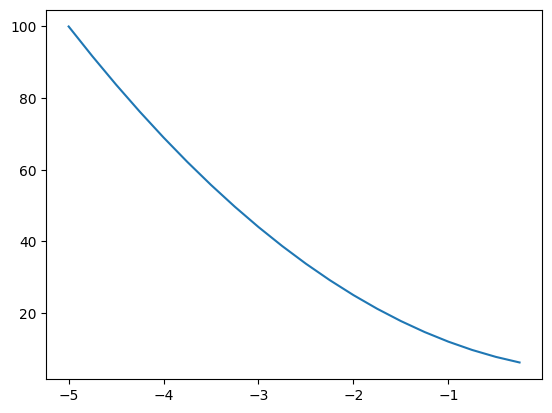

In [61]:
xs = np.arange(-5, 0, 0.25)
ys= f(xs)
plt.plot(xs, ys)

In [62]:
# slope at different point
h = 0.00000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [63]:
# let get more complex

a = 2.0
b = -3.0
c = 10.0
d = a*b +c
print(d)



4.0


In [64]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0


d1 = a*b + c
c += h  # by changing varaibles by small amount tells how each value a, b, c affect d
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)



d1 4.0
d2 4.0001
slope 0.9999999999976694


In [202]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None # a function to do backprop by defaults return nothing ex on leaf node
    self._prev = set(_children)
    self._op = _op
    self.label = label
  def __repr__(self):
    return f'Value(data={self.data})'


  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)  #this because we can't add this a = value(2.0) -> a * 2 or a * 2
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only support int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out



  def __rmul__(self, other): #other * self this to be able to do other side of operation in different direction
    return self * other


  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1


  def __sub__(self, other): #self - other
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1- t**2) * out.grad
    out._backward = _backward
    return out


  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
        node._backward()

a = Value(2.0,  label='a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label= 'd'
f = Value(-2.0, label= 'f')
L = d * f; L.label = 'L'

L

Value(data=-8.0)

In [66]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [67]:
d._op

'+'

In [68]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [69]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f |grad %.4f }" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


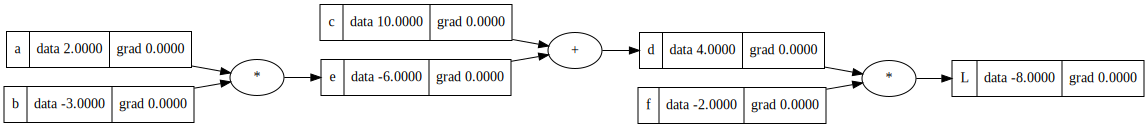

In [70]:
draw_dot(L)

In [71]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2

In [72]:
# dL/ dc derivative of L with respect to C

# dd /dc? 1.0
#(f(x + h)- f(x)) / h definition of derivative

#d = c + e
#((c+h +e )- (c + e))/h
#(c + h + e - c - e)/ h # c, e cancel out
#h/h is 1.0
"""
dd / dc = 1.0
dd/ de  = 1.0
d = c + e

want:
dL/ dc = (dL/ dd) * (dd / dc)


know:

dL / dd
dd / dc
"""


c.grad = -2.0
e.grad = -2.0



"""
We need to find DL/DA and DL/DB
BY CHAIN RULE

DL/DA = DL/DE * DE/DA
DL/DB = DL/DE * DE / DB

"""

a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [73]:

# show how each value affect L by increasing L one by small nu
def lol():

  h = 0.001

  a = Value(2.0,  label='a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label= 'd'
  f = Value(-2.0, label= 'f')
  L = d * f; L.label = 'L'
  L1 = L.data


  a = Value(2.0 ,  label='a')
  b = Value(-3.0 , label = 'b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label= 'd'
  f = Value(-2.0, label= 'f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

0.0


In [74]:
#preview of one single optimization to minimize L

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.data

e = a * b
d = e + c
L = d * f

print(L.data)

-36.637952


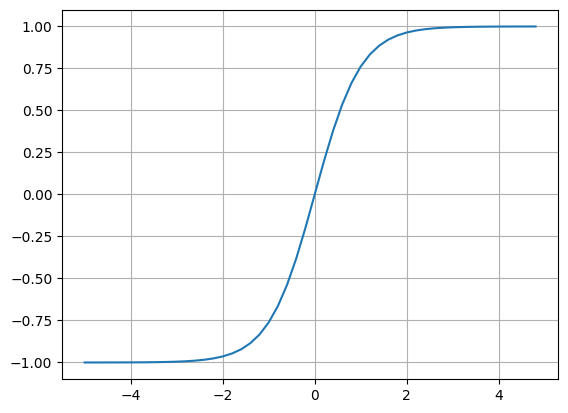

In [75]:
# manual Backpropagation example #2

plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)));plt.grid();





# manual Backpropagation example #2

In [76]:
# manual Backpropagation example #2
"""In training a neural network, what matters most is the gradient, not the exact form of the function. As long as the function is differentiable and you understand how changes in the input affect the output, you can train it effectively."""
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = '0' # as long as we know the derivative of tanh will be able to backpropagate


o.backward()



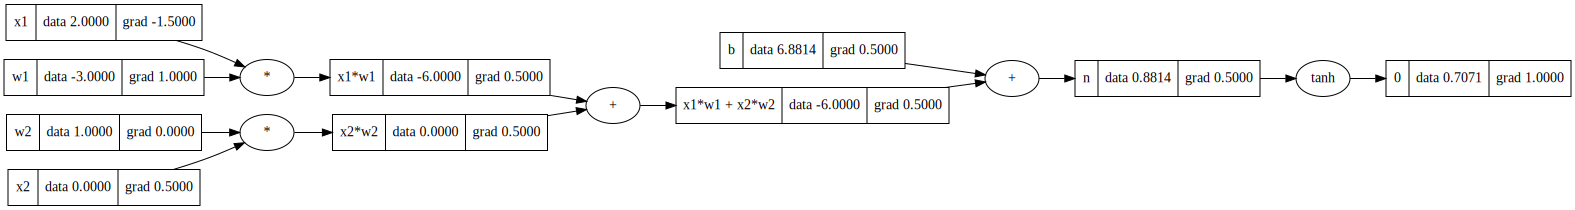

In [77]:
draw_dot(o)

In [78]:
o.backward()

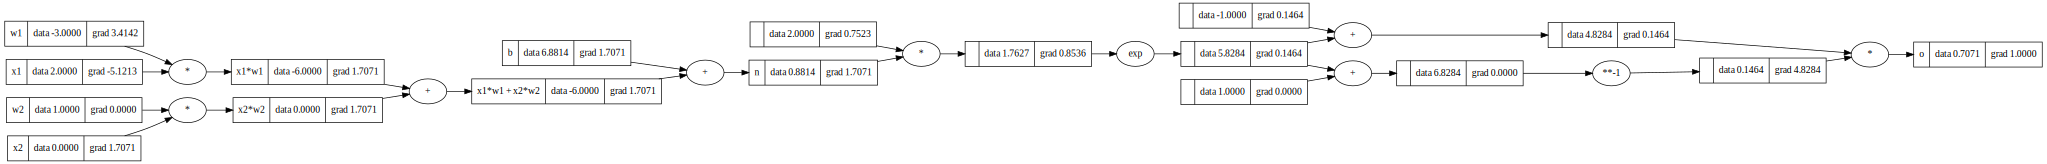

In [79]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

#------
e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'
o.backward()
draw_dot(o)


In [80]:
# we want to implement grad of values after we are done with grad of the value it depends on which is visited node

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()



#Implement grad and mannual implementation

In [81]:
o.grad = 1.0

In [82]:
o._backward()

In [83]:
n._backward()

In [84]:
b._backward() #be is node

In [85]:
x1w1x2w2._backward()

In [86]:
x2w2._backward()
x1w1._backward()


In [87]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [88]:
o.grad = 1.0
x1w1.grad = 0.5
x2w2.grad = 0.5

In [89]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [90]:
n.grad = 0.5

In [91]:
o.data

0.7071067811865477

In [92]:
#  o = tanh(n)
# do/dn = 1 - tanh(n) ** 2

In [93]:
n.grad = 1 - o.data **2
n.grad

0.4999999999999998

In [94]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

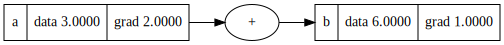

In [95]:
#isues of the bug if we use one variable more than once the gradient are not correct #  fixed it by adding all the gradient

a = Value(3.0, label ='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

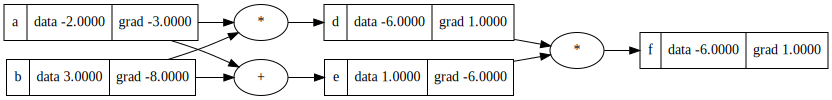

In [96]:

a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()


draw_dot(f)



## Doing the same things in Pytorch

In [97]:
import torch
import random

In [98]:
x1 = torch.Tensor([2.0]).double()                      ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                      ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                     ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                      ;w2.requires_grad = True
b  = torch.Tensor([6.8813735870195432]).double()       ;b.requires_grad = True
n = x1*w1 + x2*w2+b
o = torch.tanh(n)

print(o.data.item())
o.backward()


print('——')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
——
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Building neuron


In [107]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range (nin)]
    self.b = Value(random.uniform(-1, 1))
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi  for wi, xi in zip(self.w, x)), self.b) #zip pair wi with xi
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range (nout)]


  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:


  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]




# x = [2.0, 3.0]
# n = Neuron(2)
# n(x)



# x = [2.0, 3.0]
# n = Layer(2, 3)
# n(x)









Value(data=-0.982307353389343)

In [288]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.15934543562787484)

In [110]:
n.parameters()

[Value(data=-0.649044114880204),
 Value(data=0.0975290257252468),
 Value(data=0.28654622062646085),
 Value(data=-0.4770747346775652),
 Value(data=0.8861458521996148),
 Value(data=-0.1392041423398942),
 Value(data=0.5844382759999673),
 Value(data=-0.35510207566397),
 Value(data=0.26851398278191785),
 Value(data=0.4011671037260647),
 Value(data=-0.3081550558481332),
 Value(data=-0.1074688897888223),
 Value(data=-0.41524669610300013),
 Value(data=-0.9624655357805794),
 Value(data=-0.563701896382024),
 Value(data=0.7667190690157433),
 Value(data=0.1324032763346943),
 Value(data=0.05418506580467919),
 Value(data=0.5561168477144189),
 Value(data=-0.7023613750733322),
 Value(data=0.805512000580392),
 Value(data=0.032319668794298595),
 Value(data=0.18640969485869285),
 Value(data=-0.0984308323385823),
 Value(data=0.48361497715651014),
 Value(data=-0.6119969504898082),
 Value(data=-0.316478639774298),
 Value(data=-0.5414354338754639),
 Value(data=-0.6467788007482129),
 Value(data=0.528631883329

In [100]:
#draw_dot(n(x))

In [289]:
# Creating dataset

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0] # desired targets


In [291]:

for k in range(20):

  # forword pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))


  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update

  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k, loss.data)



0 5.172305713496055e-06
1 2.3921830327950993e-06
2 1.1200735864185016e-06
3 5.289618879318104e-07
4 2.517426180016208e-07
5 1.207620379098753e-07
6 5.84380165286411e-08
7 2.856255498565072e-08
8 1.4123724883921721e-08
9 7.079908760616875e-09
10 3.606377631159219e-09
11 1.8719180414338604e-09
12 9.932375523463357e-10
13 5.406551617769867e-10
14 3.031153874633051e-10
15 1.7579570414182082e-10
16 1.0597872427899288e-10
17 6.678081229120657e-11
18 4.428995907061894e-11
19 3.121162866307378e-11


In [130]:
# # How do we tune the weight to  better peforme


# loss = [yout - ygt for ygt, yout in zip(ys, ypred)]

# loss

In [203]:
# ypred =  [n(x) for x in xs]
# ypred
# loss = sum((yout - ygt)**2  for ygt, yout in zip(ys, ypred))
# loss

Value(data=3.78519607579341)

In [204]:
# loss.backward()

In [206]:
# n.layers[1].neurons[0].w[0].grad

0.1123943120066697

In [207]:
# n.layers[0].neurons[0].w[0].data

-0.649044114880204

In [270]:
# #the loss went down little
# ypred =  [n(x) for x in xs]
# ypred
# loss = sum((yout - ygt)**2  for ygt, yout in zip(ys, ypred))

# loss

Value(data=7.1092418761864185)

In [271]:
loss.backward()

In [272]:
# for p in n.parameters():
#   p.data += -0.1 * p.grad


In [274]:
# ypred

[Value(data=-0.9946615808690809),
 Value(data=0.7688278527009712),
 Value(data=-0.9573962266864877),
 Value(data=-0.9295724162576064)]

In [276]:
# n.parameters()

[Value(data=-0.6369954005481191),
 Value(data=0.10496396578196013),
 Value(data=0.2788596701911352),
 Value(data=-0.4750171303779821),
 Value(data=0.957818293884382),
 Value(data=-0.025432259045128323),
 Value(data=0.5429971122367259),
 Value(data=-0.32050116703206033),
 Value(data=0.1357102626204133),
 Value(data=0.4573567512055071),
 Value(data=-0.3565233669743838),
 Value(data=-0.16253052287559505),
 Value(data=-0.13152847839544304),
 Value(data=-1.0616757715798921),
 Value(data=-0.5074260067230848),
 Value(data=0.8648312523148763),
 Value(data=0.023541281759585198),
 Value(data=0.1411123901532999),
 Value(data=0.3835516987759804),
 Value(data=-0.5574422431518078),
 Value(data=0.9118049241868085),
 Value(data=0.19638956689345127),
 Value(data=0.04523936369165035),
 Value(data=0.022433528413065867),
 Value(data=0.36458540648569615),
 Value(data=-0.777243588879192),
 Value(data=-0.2370709378785746),
 Value(data=-0.5625936244158597),
 Value(data=-0.7265483775424045),
 Value(data=0.6141